In [41]:
import pandas as pd
import random
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import IsolationForest
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from scipy.stats import gaussian_kde
import numpy as np
import joblib

In [42]:
# simulate dataset

def generate_upi_handle():
    names = ['sumit', 'ivy', 'aryan','ananya','amit','anandi','kaavya','saumya','devansh','gursheel','paytmcash', 'fastfood', 'insurance', 'grocery', 'helpline', 'sbihelpdesk','ishaan','paypal']
    domains = ['@ybl', '@paytm', '@upi', '@okicici', '@okhdfcbank', '@okaxis', '@fam']
    return random.choice(names) + random.choice(domains)

def generate_suspicious_handle():
    suspicious_handles=['loanoffer','fastrefund','refund','helpline','helpdesk','verify','cashback','reward',]
    suspicious_domains = ['@customercareupi','@okrefund','@okhdfcbnk','@okaxisback','@okicicii','@oksbibank','@googlepay','@paypal']
    random_num=''
    if random.randint(0,1):
        random_num=str(random.randint(11,99))
    return random.choice(suspicious_handles) + random_num + random.choice(suspicious_domains)
    
def generate_dataset(n=20000):
    data = []
    for _ in range(n):
        if random.random() < 0.90:
            upi = generate_upi_handle()
            reports = random.randint(0, 5)
        else:
            upi=generate_suspicious_handle()
            reports = random.randint(100, 500)
        data.append([upi, reports])
    return pd.DataFrame(data, columns=['UPI', 'REPORTS'])

In [43]:
#extract features

def extract_username(handle):
    return handle.partition('@')[0]
def extract_domain(handle):
    return handle.partition('@')[2]
def detect_digits(handle):
    for i in handle:
        if(i.isdigit()):
            return 1;
    return 0;

def extract_features(df):
    df['USERNAME']=df['UPI'].apply(extract_username)
    df['DOMAIN']=df['UPI'].apply(extract_domain)
    df['HANDLE_LENGTH'] = df['UPI'].apply(len)
    df['HAS_DIGITS'] = df['USERNAME'].apply(detect_digits)
    scam_keywords = ['refund', 'loan','cash' , 'reward', 'verify']
    df['HAS_KEYWORDS'] = df['USERNAME'].apply(lambda x: any(k in x.lower() for k in scam_keywords))


In [44]:
# Pipeline for Isolation Forest

def create_pipeline(df):
    # Select features
    features = ['REPORTS', 'DOMAIN', 'HANDLE_LENGTH', 'HAS_DIGITS', 'HAS_KEYWORDS']
    
    # Define preprocessing
    preprocessor = ColumnTransformer(transformers=[
        ('num', StandardScaler(), ['REPORTS', 'HANDLE_LENGTH']),
        ('cat', OneHotEncoder(handle_unknown='ignore',sparse_output=False), ['DOMAIN']),
        ('passthrough', 'passthrough', ['HAS_DIGITS', 'HAS_KEYWORDS'])
    ])
    model=IsolationForest(contamination=0.1, random_state=42)
    pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)])
    pipeline.fit(df[features])
    
    return pipeline,model,features



In [56]:
# Predict anomalies

def anomaly(df,pipeline):
    df['ANOMALY'] = pipeline.predict(df[features])  # -1 = anomaly, 1 = normal

def print_df(df):
    print(df.head())

In [46]:
# Silhoutte score
def silhoutte_score(df,pipeline,features):
    X_transformed = pipeline.named_steps['preprocessor'].transform(df[features])
    X_dense = X_transformed.toarray() if hasattr(X_transformed, 'toarray') else X_transformed
    labels = df['ANOMALY']
    score = silhouette_score(X_dense, labels)
    print()
    print(f'Silhouette Score: {score}')
    print()

# Score:-
# Range: -1 to 1
# Closer to 1 = better clustering
# Close to 0 = overlapping clusters
# Negative = incorrect clustering

In [47]:
#  calinski_harabasz_score

def calinski_score(df,pipeline,features):
    X_transformed = pipeline.named_steps['preprocessor'].transform(df[features])
    X_dense = X_transformed.toarray() if hasattr(X_transformed, 'toarray') else X_transformed
    labels = df['ANOMALY']
    ch_score = calinski_harabasz_score(X_dense, labels)
    print()
    print(f"Calinski-Harabasz Score: {ch_score}")
    print()

In [48]:
# Anomaly visualisation

def anomaly_visualisation(model,df,pipeline,features):
    X_transformed = pipeline.named_steps['preprocessor'].transform(df[features])
    X_dense = X_transformed.toarray() if hasattr(X_transformed, 'toarray') else X_transformed

    plt.figure(figsize=(10,6))
    scores = model.decision_function(X_dense)  # Higher = more normal
    plt.hist(scores, bins=50)
    plt.title("Anomaly Score Distribution")
    plt.show()

    plt.figure(figsize=(10,6))
    sns.histplot(df['ANOMALY'], bins=50, kde=True)
    plt.title("Distribution of Anomaly Scores (Isolation Forest)")
    plt.grid(True)
    plt.show()

# One large peak = normal samples (high scores)
# One small peak on the left = anomalies (low scores)
# A visible gap or dip between the two = good separation


In [49]:
# Princliple component analysis

def pca_and_density(df,pipeline,features):
    X_transformed = pipeline.named_steps['preprocessor'].transform(df[features])
    X_dense = X_transformed.toarray() if hasattr(X_transformed, 'toarray') else X_transformed
    
    # PCA
    pca = PCA(n_components=2)
    X_2d = pca.fit_transform(X_dense)
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=df['ANOMALY'],cmap='coolwarm', alpha=0.5)   
    plt.title("Anomaly Detection Visualization using PCA")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.colorbar(label="Prediction: Anomaly = -1, Normal = 1")
    plt.show()
    
    #  Density
    plt.figure(figsize=(10, 6))
    xy = np.vstack([X_2d[:,0], X_2d[:,1]])
    z = gaussian_kde(xy)(xy)
    
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=z, cmap='viridis')
    plt.title("Density Plot for Anomaly Detection")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.colorbar(label='Density: Yellow = Highly Densed, Purple = Less Dense')


In [50]:
df = generate_dataset()
df.to_csv('upi_anomaly_dataset.csv', index=False)

In [51]:
df=pd.read_csv('upi_anomaly_dataset.csv')

extract_features(df)
pipeline,model,features=create_pipeline(df)

joblib.dump(pipeline, 'upi_anomaly_pipeline.pkl')

['upi_anomaly_pipeline.pkl']

                   UPI  REPORTS   USERNAME      DOMAIN  HANDLE_LENGTH  \
0         gursheel@fam        2   gursheel         fam             12   
1  loanoffer@okhdfcbnk      302  loanoffer   okhdfcbnk             19   
2        insurance@ybl        4  insurance         ybl             13   
3  gursheel@okhdfcbank        2   gursheel  okhdfcbank             19   
4           ananya@ybl        4     ananya         ybl             10   

   HAS_DIGITS  HAS_KEYWORDS  ANOMALY  
0           0         False        1  
1           0          True       -1  
2           0         False        1  
3           0         False        1  
4           0         False        1  

Silhouette Score: 0.5482001434126834


Calinski-Harabasz Score: 11371.885457529263



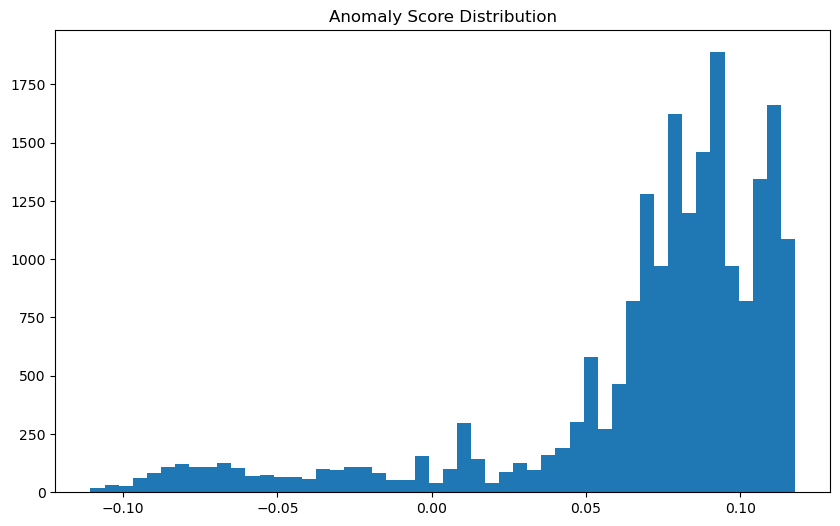

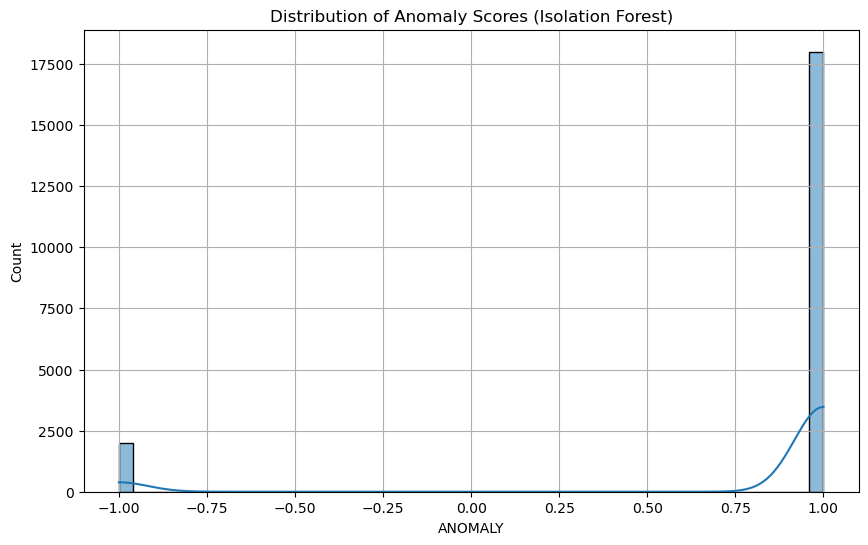

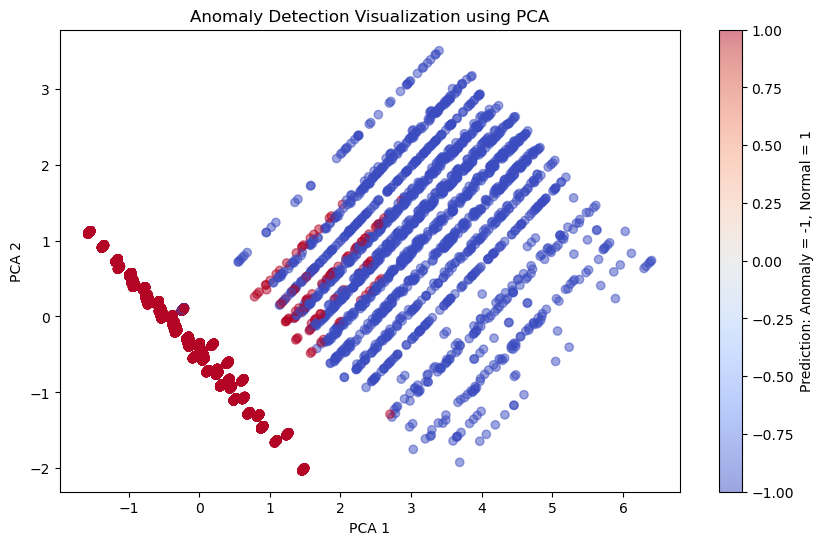

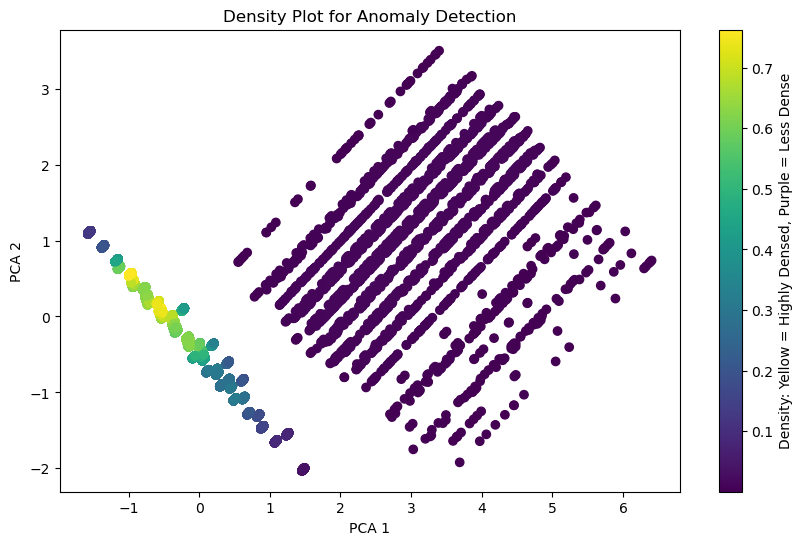

In [53]:
pipeline=joblib.load('upi_anomaly_pipeline.pkl')
anomaly(df,pipeline)
print_df(df)

silhoutte_score(df,pipeline,features)
calinski_score(df,pipeline,features)

anomaly_visualisation(model,df,pipeline,features)
pca_and_density(df,pipeline,features)